<a href="https://colab.research.google.com/github/Ayoub-cyborg/Sentiment-analyses-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec

Data Importation

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Cell_Phones_and_Accessories_5.json'

In [ ]:
df = pd.read_json(dataset_path, lines=True)
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1381536000,"10 12, 2013"
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5,best thing ever..,1377129600,"08 22, 2013"
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1384992000,"11 21, 2013"
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,1380067200,"09 25, 2013"
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5,Perfect Case,1396483200,"04 3, 2014"


In [ ]:
df.tail(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
194429,AF30DHAVSYNZ0,B00LH1R6SK,Sasha DLH,"[0, 0]","Ahah, I love it. The case looks better than th...",5,Yesssssss!,1405641600,"07 18, 2014"
194430,A34KTJ4VWNBOHI,B00LH1R6SK,Stina,"[0, 0]","As someone who owns an iPhone, I absolutely lo...",5,Beautiful Color and Texture,1405641600,"07 18, 2014"
194431,A1Q1Z7IR79G52A,B00LORXVUE,"Ann Ingersoll Madison Rain ""Ann""","[0, 0]",What a high quality cable. Right out of the pa...,5,"Must have, high quality charging cable for ipa...",1405987200,"07 22, 2014"
194432,A388OX0ZF7OT8R,B00LORXVUE,Chuck.C,"[0, 0]",This one actually works unlike some others I b...,4,Long Wire,1405728000,"07 19, 2014"
194433,A2BLFCOPSMBOZ9,B00LORXVUE,Dave Edmiston,"[0, 0]","I don't like the word ""hate"", so let's just sa...",5,Awesome cable!,1405641600,"07 18, 2014"
194434,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,"[0, 0]",Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014"
194435,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,"[0, 0]",Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014"
194436,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"[0, 0]","This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014"
194437,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,"[0, 0]",I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014"
194438,A1AG6U022WHXBF,B00LORXVUE,Trisha Crocker,"[0, 0]","product as described, I have wasted a lot of m...",5,I have wasted a lot of money on cords,1405900800,"07 21, 2014"


To build an sentiments analyses model, w'are intersting just in the reviewText and overall columns, so we extract just the two columns and drop others columns

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime']
df = df.drop(columns_to_drop, axis=1)

In [ ]:
# Verify the updated DataFrame
df.head

<bound method NDFrame.head of                                                reviewText  overall
0       They look good and stick good! I just don't li...        4
1       These stickers work like the review says they ...        5
2       These are awesome and make my phone look so st...        5
3       Item arrived in great time and was in perfect ...        4
4       awesome! stays on, and looks great. can be use...        5
...                                                   ...      ...
194434  Works great just like my original one. I reall...        5
194435  Great product. Great packaging. High quality a...        5
194436  This is a great cable, just as good as the mor...        5
194437  I really like it becasue it works well with my...        5
194438  product as described, I have wasted a lot of m...        5

[194439 rows x 2 columns]>

In [ ]:
#Verify messing value
missing_values_count = df.isnull().sum()
print(missing_values_count)

reviewText    0
overall       0
dtype: int64


NB: wa observe that, when the over all is less or equal 2 the review is negative, and when it heigher then 2 the review is positive, so after this step we encode the overall column to 1-->positve , 0 ---> negative

In [ ]:
filtered_df = df.loc[df['overall'] <=2, 'reviewText']
print(filtered_df)

7         it worked for the first week then it only char...
19        It worked great for the first couple of weeks ...
26        I am disappointed that the 1A didn't work with...
28                         After a week only one side works
32        Only works one side at a time. When you connec...
                                ...                        
194299    I would not recommend this to anyone. The mate...
194302    I used to have this case for my ipods and they...
194304    I tried to like this product, I got a Warrenty...
194309    This is okay if you don't ever need to access ...
194346                              Not OEM, cheap knockoff
Name: reviewText, Length: 24343, dtype: object


In [ ]:
filtered_df = df.loc[df['overall'] >2, 'reviewText']
print(filtered_df)

0         They look good and stick good! I just don't li...
1         These stickers work like the review says they ...
2         These are awesome and make my phone look so st...
3         Item arrived in great time and was in perfect ...
4         awesome! stays on, and looks great. can be use...
                                ...                        
194434    Works great just like my original one. I reall...
194435    Great product. Great packaging. High quality a...
194436    This is a great cable, just as good as the mor...
194437    I really like it becasue it works well with my...
194438    product as described, I have wasted a lot of m...
Name: reviewText, Length: 170096, dtype: object


In [ ]:
#Transformation de la variables cibles en une variable numérique binaire
# 0: negative ; 1: positive
df['overall'] = df['overall'].apply(lambda val: 0 if val <=2 else 1)

In [ ]:
df['overall'].value_counts(normalize=True)

1    0.874804
0    0.125196
Name: overall, dtype: float64

<Axes: ylabel='overall'>

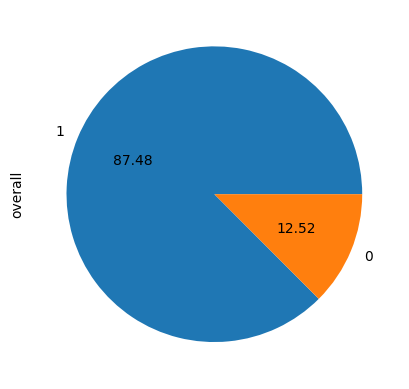

In [ ]:
df['overall'].value_counts().plot.pie(autopct='%.2f')

**We observe that we have imbalanced data**




In [ ]:
! pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Over-Sampling  Methode**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

X = df.drop('overall', axis=1)
y = df['overall']

# Create an instance of RandomOverSampler
random_oversampler = RandomOverSampler()

# Perform over-sampling
X_resampled, y_resampled = random_oversampler.fit_resample(X, y)


<Axes: ylabel='overall'>

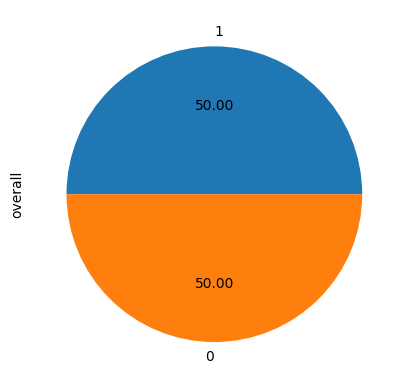

In [ ]:
y_resampled.value_counts().plot.pie(autopct='%.2f')

Split the data to tarin and test and validate

In [ ]:
from sklearn.model_selection import train_test_split

seed = 123

# Split the resampled data into train and test sets, preserving class distribution
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=seed, stratify=y_resampled)

# Split the test set into test and validation sets, preserving class distribution
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, stratify=y_test)

# Combine the training data into one DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combine the testing data into one DataFrame
test = pd.concat([X_test, y_test], axis=1)

# Combine the validation data into one DataFrame
valid = pd.concat([X_val, y_val], axis=1)

print("train data: ", train.shape)
print("Validation data: ", valid.shape)
print("test data: ", test.shape)

train data:  (238134, 2)
Validation data:  (51029, 2)
test data:  (51029, 2)


In [ ]:
train.tail

<bound method NDFrame.tail of                                                reviewText  overall
89510   Great product, works awesome and as described....        1
98052   I purchase quite a few things from Amazon.com ...        1
308616  I got this and loved it at first but then I wa...        0
316085  Installed the screen, turned on the phone and....        0
225555  No instructions. Came in a little plastic bagg...        0
...                                                   ...      ...
223283  For an iPad to be charged efficiently without ...        0
86179   Frustration is the keyword to describe this Bl...        0
110210  The battery is bigger than the original and ad...        1
289531  Stopped working after a week, but I guess the ...        0
320372  i would not recommend  this case to any body i...        0

[238134 rows x 2 columns]>

In [ ]:
#Save data
train.to_csv('/content/drive/MyDrive/Sentiments analyses project/train.csv', index=False)
valid.to_csv('/content/drive/MyDrive/Sentiments analyses project/validate.csv', index=False)
test.to_csv('/content/drive/MyDrive/Sentiments analyses project/test.csv', index=False)

Data Processing

In [ ]:
def preprocess_text(text):

    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)

    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Combine words back into a single string
    preprocessed_text = ' '.join(words)

    return preprocessed_text

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
train['preprocessed_text']= train['reviewText'].apply(preprocess_text)
test['preprocessed_text']= test['reviewText'].apply(preprocess_text)
valid['preprocessed_text']= valid['reviewText'].apply(preprocess_text)

In [ ]:
train.head()

,reviewText,overall
89510,"Great product, works awesome and as described....",1
98052,I purchase quite a few things from Amazon.com ...,1
308616,I got this and loved it at first but then I wa...,0
316085,"Installed the screen, turned on the phone and....",0
225555,No instructions. Came in a little plastic bagg...,0


Vectorieation using BOW, TF-IDF, Word2vec

In [ ]:
def train_svm_with_representations(data_train, data_test, representation):
    if representation == 'bow':
        vectorizer = CountVectorizer()
    elif representation == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Invalid representation. Choose 'bow' or 'tfidf'.")

    X_train = vectorizer.fit_transform(data_train)
    X_test = vectorizer.transform(data_test)

    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return y_pred

In [ ]:
def get_word2vec_embeddings(data):
    tokenized_sentences = [sentence.split() for sentence in data]
    model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
    
    # Initialize an empty array to store the embeddings
    embeddings = np.zeros((len(tokenized_sentences), model.vector_size))
    
    # Populate the embeddings array with word vectors
    for i, sentence in enumerate(tokenized_sentences):
        word_vectors = [model.wv[word] for word in sentence if word in model.wv]
        if word_vectors:
            embeddings[i] = np.mean(word_vectors, axis=0)
    
    return embeddings

def train_svm_with_word2vec(data_train, data_test, y_train):
    X_train = get_word2vec_embeddings(data_train)
    X_test = get_word2vec_embeddings(data_test)
    
    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return y_pred


In [ ]:
X_train = train['preprocessed_text']
y_train = train['overall']
X_test = test['preprocessed_text']
y_test = test['overall']

In [ ]:
# Bag of Words
y_pred_bow = train_svm_with_representations(X_train, X_test, 'bow')
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(accuracy_bow)

In [ ]:
# TF-IDF
y_pred_tfidf = train_svm_with_representations(X_train, X_test, 'tfidf')
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(accuracy_tfidf)

In [ ]:
# Word2Vec with preprocessed data
y_pred_word2vec = train_svm_with_word2vec(X_train, X_test, y_train)
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print(accuracy_word2vec)

In [ ]:
X_train = train['reviewText']
y_train = train['overall']
X_test = test['reviewText']
y_test = test['overall']

In [ ]:
# Word2Vec with row data
y_pred_word2vec = train_svm_with_word2vec(X_train, X_test, y_train)
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print(accuracy_word2vec)

**Vanilla RNN Model**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Preparing the data
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['preprocessed_text'])

X_train = tokenizer.texts_to_sequences(train['preprocessed_text'])
X_test = tokenizer.texts_to_sequences(test['preprocessed_text'])
X_valid = tokenizer.texts_to_sequences(validate['preprocessed_text'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)

y_train = to_categorical(train['overall'])
y_test = to_categorical(test['overall'])
y_valid = to_categorical(validate['overall'])

# Build the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(2, activation='softmax'))

# Compile the model validation_data
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test accuracy of vanilla RNN with preprocessed_text:", accuracy)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Preparing the data
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['reviewText'])

X_train = tokenizer.texts_to_sequences(train['reviewText'])
X_test = tokenizer.texts_to_sequences(test['reviewText'])
X_valid = tokenizer.texts_to_sequences(validate['reviewText'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)

y_train = to_categorical(train['overall'])
y_test = to_categorical(test['overall'])
y_valid = to_categorical(validate['overall'])

# Build the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(2, activation='softmax'))

# Compile the model validation_data
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test accuracy of vanilla RNN with row data:", accuracy)

**LSTM Model**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report


# Preparing the data
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['preprocessed_text'])

X_train = tokenizer.texts_to_sequences(train['preprocessed_text'])
X_test = tokenizer.texts_to_sequences(test['preprocessed_text'])
X_valid = tokenizer.texts_to_sequences(valid['preprocessed_text'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)

y_train = to_categorical(train['overall'])
y_test = to_categorical(test['overall'])
y_valid = to_categorical(valid['overall'])

# Build the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test accuracy of LSTM model with preprocessed_text :", accuracy)

In [ ]:
#Create Pipeline
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

myPipeline = Pipeline(steps=[('tokenizer', Tokenizer(num_words=10000)), ('model', Sequential())])
myPipeline

Pipeline(steps=[('tokenizer',
                 <keras.preprocessing.text.Tokenizer object at 0x7f7ec678f670>),
                ('model',
                 <keras.engine.sequential.Sequential object at 0x7f7ec678e050>)])

In [ ]:
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Create Pipeline
myPipeline = Pipeline(steps=[('tokenizer', Tokenizer(num_words=10000)), ('model', Sequential())])

# Preparing the data
max_words = 10000
max_len = 100

# Tokenizer
myPipeline.named_steps['tokenizer'].fit_on_texts(train['reviewText'])
X_train = myPipeline.named_steps['tokenizer'].texts_to_sequences(train['reviewText'])
X_test = myPipeline.named_steps['tokenizer'].texts_to_sequences(test['reviewText'])
X_valid = myPipeline.named_steps['tokenizer'].texts_to_sequences(valid['reviewText'])

# Padding
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)

# Categorical labels
y_train = to_categorical(train['overall'])
y_test = to_categorical(test['overall'])
y_valid = to_categorical(valid['overall'])

# Build the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))

# Set model in the pipeline
myPipeline.named_steps['model'] = model

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test accuracy of LSTM model with raw data:", accuracy)


Epoch 1/10
1861/1861 [==============================] - 466s 249ms/step - loss: 0.3108 - accuracy: 0.8697 - val_loss: 0.2454 - val_accuracy: 0.9024
Epoch 2/10
1861/1861 [==============================] - 449s 241ms/step - loss: 0.1969 - accuracy: 0.9255 - val_loss: 0.1999 - val_accuracy: 0.9276
Epoch 3/10
1861/1861 [==============================] - 469s 252ms/step - loss: 0.1392 - accuracy: 0.9512 - val_loss: 0.1671 - val_accuracy: 0.9444
Epoch 4/10
1861/1861 [==============================] - 466s 251ms/step - loss: 0.1050 - accuracy: 0.9646 - val_loss: 0.1625 - val_accuracy: 0.9458
Epoch 5/10
1861/1861 [==============================] - 474s 255ms/step - loss: 0.0807 - accuracy: 0.9736 - val_loss: 0.2023 - val_accuracy: 0.9394
Epoch 6/10
1861/1861 [==============================] - 473s 254ms/step - loss: 0.0613 - accuracy: 0.9805 - val_loss: 0.1955 - val_accuracy: 0.9448
Epoch 7/10
1861/1861 [==============================] - 495s 266ms/step - loss: 0.0480 - accuracy: 0.9849 - val_

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Preparing the data
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['reviewText'])

X_train = tokenizer.texts_to_sequences(train['reviewText'])
X_test = tokenizer.texts_to_sequences(test['reviewText'])
X_valid = tokenizer.texts_to_sequences(valid['reviewText'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)

y_train = to_categorical(train['overall'])
y_test = to_categorical(test['overall'])    
y_valid = to_categorical(valid['overall'])

# Build the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test accuracy of LSTM model with raw data:", accuracy)

# Classification Report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)


Epoch 1/10
1861/1861 [==============================] - 495s 264ms/step - loss: 0.3082 - accuracy: 0.8699 - val_loss: 0.2410 - val_accuracy: 0.9056
Epoch 2/10
1861/1861 [==============================] - 500s 269ms/step - loss: 0.1959 - accuracy: 0.9254 - val_loss: 0.1876 - val_accuracy: 0.9321
Epoch 3/10
1861/1861 [==============================] - 501s 269ms/step - loss: 0.1401 - accuracy: 0.9505 - val_loss: 0.1643 - val_accuracy: 0.9422
Epoch 4/10
1861/1861 [==============================] - 505s 271ms/step - loss: 0.1019 - accuracy: 0.9659 - val_loss: 0.1486 - val_accuracy: 0.9533
Epoch 5/10
1861/1861 [==============================] - 501s 269ms/step - loss: 0.0771 - accuracy: 0.9754 - val_loss: 0.1526 - val_accuracy: 0.9542
Epoch 6/10
1861/1861 [==============================] - 504s 271ms/step - loss: 0.0586 - accuracy: 0.9817 - val_loss: 0.1698 - val_accuracy: 0.9535
Epoch 7/10
1861/1861 [==============================] - 506s 272ms/step - loss: 0.0439 - accuracy: 0.9868 - val_

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.12.0


In [ ]:
#Save the model 
# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 1,329,538
Trainable params: 1,329,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('/content/drive/MyDrive/saved_model/my_model')

In [14]:
import tensorflow as tf
import joblib
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model')
tokenizer = joblib.load("/content/drive/MyDrive/tokenizer1.0.1.pkl")

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 1,329,538
Trainable params: 1,329,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Input text

text = ["I don't recommand to use python guys"]
sequences = tokenizer.texts_to_sequences(text)
padded_sequences = pad_sequences(sequences, maxlen=100)  # Assuming the same max_len value as in the previous code


# Make predictions using the loaded model
predictions = new_model.predict(padded_sequences)
print(predictions)

1/1 [==============================] - 0s 77ms/step
[[0.9830497  0.01695034]]


In [25]:
import numpy as np
# Assuming you have loaded the predictions into the 'predictions' variable

sentiment_labels = ['negative', 'positive']

# Check if predictions exist
if predictions.shape[0] > 0:
    # Classify the sentiment based on the prediction probabilities
    classified_sentiment = sentiment_labels[np.argmax(predictions[0])]
else:
    # Unable to classify se ntiment
    classified_sentiment = "Unknown"

# Print the input sentence and the classified sentiment
print("Input Sentence:", text[0])
print("Sentiment:", classified_sentiment)

Input Sentence: I don't recommand to use python guys
Sentiment: negative


**Transformer Based Models (DistilBERT and Roberta)**




In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.7 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

In [ ]:
data_texts = df['reviewText'].to_list()
data_labels = df['overall'].to_list()

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

In [ ]:
#Model Definition
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [ ]:
# Create TensorFlow datasets
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

**Fine-tuning with the TFTrainer class**

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2 )


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
) 

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
import os
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
import numpy as np

# Detect TPU and set up distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tpu.connect()
tpu_strategy = tf.distribute.TPUStrategy(tpu)

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_len = 512
X_train = tokenizer(text=train['preprocessed_text'].tolist(), add_special_tokens=True, max_length=max_len, truncation=True, padding=True, return_tensors='tf')
y_train = train['overall'].values

X_train_np = X_train['input_ids'].numpy()
X_train_np, X_val_np, y_train, y_val = train_test_split(X_train_np, y_train, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val)).batch(16)

with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

batch_size = 16
epochs = 5
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

X_test = tokenizer(text=test['preprocessed_text'].tolist(), add_special_tokens=True, max_length=max_len, truncation=True, padding=True, return_tensors='tf')
y_test = test['overall'].values

# Convert the test dataset into a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test['input_ids'], X_test['attention_mask'])).batch(16)

y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred.logits, axis=1)
accuracy = np.sum(y_pred_labels == y_test) / len(y_test)
print(f"Test accuracy of DistilBert Transformers with preprocessed_text: {accuracy:.2f}")

NameError: ignored